# Base séquentielle des parcours de soins patients

Ce notebook a pour objectif de déterminer les flux de patients, c'est-à-dire visualiser les proportions de GHM et DP selon les hospitalisations successives.

In [115]:
#Import des librairies

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px

In [116]:
%%capture capt
p_soins=pd.read_csv("./data/parcours_soins.csv")

In [117]:
p_soins.head()

,BEN_NIR_IDT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Création de la base séquentielle d'hospitalisations

### Pour l'ensemble de la population

In [118]:
p_soins_list=[]
for patient in tqdm(range(len(p_soins))):
    p_soins_list.append(p_soins.iloc[patient].dropna().tolist()[0:-1])

100%|███████████████████████████████████████████████████████████████████████████| 10051/10051 [00:16<00:00, 598.36it/s]


Dans la base séquentielle ci-dessous, les différentes colonnes correspondent aux hospitalisations successives. Ainsi, on trouve dans la 1ère colonne le GHM de la 1ère hospitalisation, pour chacun des patients suivis.

In [119]:
p_soins_df=pd.DataFrame(p_soins_list)
p_soins_df.head()

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,P0,05K051,05M042,05M16T,05M09T,05M092,05C191,05M20Z,05M20Z,None,...,None,None,None,None,None,None,None,None,None,None
1,P6,02C05J,02C05J,05M093,04M132,05C222,23M103,04M053,None,None,...,None,None,None,None,None,None,None,None,None,None
2,P8,11M041,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,P13,05M04T,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,P16,08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M101,05K191,None,...,None,None,None,None,None,None,None,None,None,None


### CdF du nombre d'hospitalisations

In [120]:
p_soins_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
count,10051,9543,8786,7830,6868,5868,4986,4223,3567,3034,...,1,1,1,1,1,1,1,1,1,1
unique,10051,1410,1391,1251,1166,1074,972,901,835,768,...,1,1,1,1,1,1,1,1,1,1
top,P0,02C05J,02C05J,02C05J,05M092,05M092,05M092,05M092,05M092,05M092,...,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T
freq,1,358,452,291,270,197,187,167,123,130,...,1,1,1,1,1,1,1,1,1,1


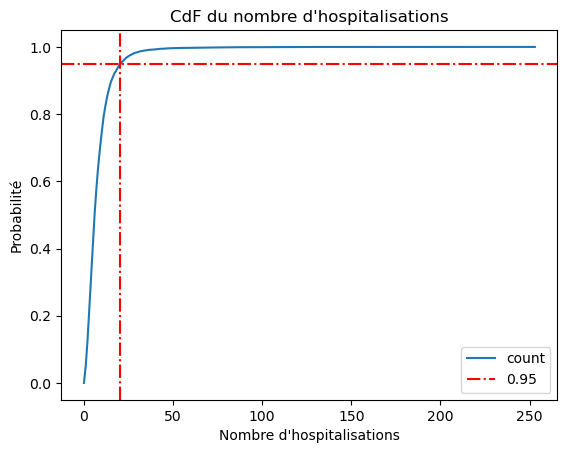

In [121]:
(1-p_soins_df.describe().iloc[0]/len(p_soins_list)).plot()
#plt.axhline(y = 0.5, color='r', linestyle='-', label="0.5")
#plt.axhline(y = 0.05, color='r', linestyle='--', label="0.05")
plt.axhline(y = 0.95, color='r', linestyle='-.', label="0.95")
plt.axvline(x = 20, color='r', linestyle='-.')
plt.xlabel("Nombre d'hospitalisations")
plt.ylabel("Probabilité")
plt.legend()
plt.title("CdF du nombre d'hospitalisations")
plt.show()

95% des patients de la population étudiée connaissent moins de 20 hospitalisations (on ne considère pas les hospitalisations chroniques).

### Pour les patients avec une hospitalisation pour un GHM '05M09x', en considérant cette hospitalisation comme début de parcours 

In [155]:
p_soins_IC=[]
for patient in tqdm(range(len(p_soins))):
    parcours=p_soins.iloc[patient].dropna()
    #Si on trouve un GHM de type '05M09x' dans le parcours de soin du patient
    if parcours.eq('05M091').any() or parcours.eq('05M092').any() or parcours.eq('05M093').any() or parcours.eq('05M094').any() or parcours.eq('05M09T').any():
        start=0
        #On cherche la 1ère hospitalisation pour IC, pour regarder le parcours de soins à partir de celle-ci
        while parcours.tolist()[start] not in ['05M091', '05M092', '05M093', '05M094','05M09T']:
            start+=1
        p_soins_IC.append([parcours[0]]+parcours.tolist()[start:-1])

100%|███████████████████████████████████████████████████████████████████████████| 10051/10051 [00:26<00:00, 372.77it/s]


In [158]:
p_soins_IC_df=pd.DataFrame(p_soins_IC)
p_soins_IC_df.head()

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
0,P0,05M09T,05M092,05C191,05M20Z,05M20Z,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,P6,05M093,04M132,05C222,23M103,04M053,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,P17,05M093,04M143,11M044,04M053,09M063,05K251,09M062,09M063,05K062,...,None,None,None,None,None,None,None,None,None,None
3,P24,05M091,05M171,05M13T,05M13T,05M13T,05K061,05M13T,05M13T,05M13T,...,None,None,None,None,None,None,None,None,None,None
4,P25,05M091,23K02Z,09C081,09C082,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### CdF du nombre d'hospitalisations après une 1ère hospitalisation pour IC

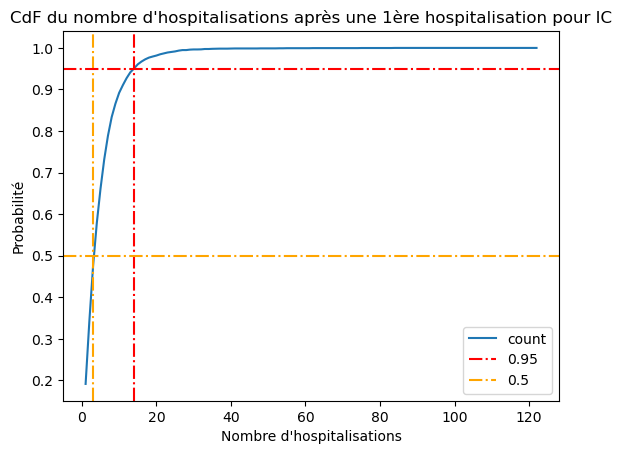

In [161]:
(1-p_soins_IC_df.drop(0, axis=1).describe().iloc[0]/len(p_soins_IC)).plot()
#plt.axhline(y = 0.5, color='r', linestyle='-', label="0.5")
#plt.axhline(y = 0.05, color='r', linestyle='--', label="0.05")
plt.axvline(x = 14, color='r', linestyle='-.')
plt.axvline(x = 3, color='orange', linestyle='-.')
plt.axhline(y = 0.95, color='r', linestyle='-.', label="0.95")
plt.axhline(y = 0.5, color='orange', linestyle='-.', label="0.5")
plt.xlabel("Nombre d'hospitalisations")
plt.ylabel("Probabilité")
plt.legend()
plt.title("CdF du nombre d'hospitalisations après une 1ère hospitalisation pour IC")
plt.show()

+ 95% des patients connaissent moins de 14 hospitalisations après une première hospitalisation pour IC
+ 50% des patients connaissent moins de 4 hospitalisations après une première hospitalisation pour IC.

## Différents GHM pour la nième hospitalisation

In [162]:
# On retire les entrées n'ayant aucune hospitalisation
p_soins_IC_df = p_soins_IC_df.drop(0, axis=1).dropna(thresh=1).reset_index(drop=True)

In [164]:
p_soins_IC_df.to_csv("data\p_soins_IC.csv")

In [163]:
p_soins_IC_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,113,114,115,116,117,118,119,120,121,122
count,3749,3053,2437,1956,1571,1243,980,772,623,502,...,1,1,1,1,1,1,1,1,1,1
unique,5,648,625,580,522,449,405,342,317,279,...,1,1,1,1,1,1,1,1,1,1
top,05M092,05M092,05M092,05M092,05M092,05M092,05M092,05M092,05M092,05M092,...,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T,04M17T
freq,1359,239,193,126,101,78,60,40,30,31,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
p_soins_IC_df

In [128]:
# On récupère le nombre de patients qui connaissent une nième hospitalisation
hospit_n=p_soins_IC_df.describe().iloc[0]
hospit_n=pd.DataFrame(hospit_n)
hospit_n.head()

,count
1,3749
2,3053
3,2437
4,1956
5,1571


In [129]:
df=pd.DataFrame()
for i in range(1,p_soins_IC_df.shape[1]):
    df=pd.concat([df, pd.DataFrame(p_soins_IC_df[i].value_counts())], axis=1)

In [130]:
df=df.transpose()
df.head()

,05M092,05M093,05M091,05M09T,05M094,05K101,02C05J,04M053,23M20Z,05K102,...,04C034,17M163,01M35T,05C214,09M111,21M152,03M073,13M051,21M151,07C071
1,1359.0,962.0,722.0,511.0,195.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,239.0,150.0,108.0,74.0,34.0,120.0,58.0,49.0,45.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,193.0,99.0,74.0,52.0,21.0,33.0,63.0,36.0,32.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,126.0,90.0,54.0,38.0,19.0,28.0,47.0,36.0,25.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,101.0,60.0,30.0,34.0,13.0,23.0,36.0,18.0,18.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dans le dataframe ci-dessus, les colonnes correspondent aux différents GHM et les lignes à la nième hospitalisation des patients insuffisants cardiaques. On retrouve donc dans chaque case le nombre d'hospitalisations pour un GHM donné, pour la nième hospitalisation.

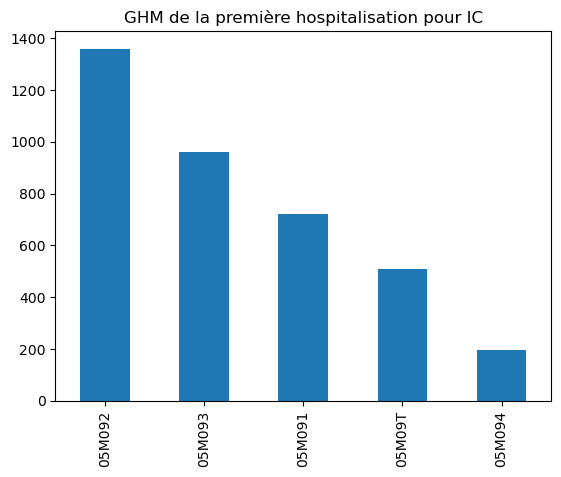

In [131]:
df.iloc[0].dropna().plot.bar()
plt.title('GHM de la première hospitalisation pour IC')
plt.show()

In [132]:
# Export des différents types d'hospitalisations et de leur nombre
df.to_csv("./data/hospit_IC.csv")

### On regroupe les GHM pour Insuffisances cardiaques ('05M091', '05M092', '05M093' et '05M09T')

In [133]:
df['05M09x']=df[['05M091', '05M092', '05M093', '05M094', '05M09T']].sum(axis=1)
df=df.drop(['05M091', '05M092', '05M093','05M094', '05M09T'], axis=1)

In [134]:
cols = list(df.columns)
cols=['05M09x']+cols[:-1]
df=df[cols]

In [135]:
df.head()

,05M09x,05K101,02C05J,04M053,23M20Z,05K102,05M081,23M20T,05M08T,05K062,...,04C034,17M163,01M35T,05C214,09M111,21M152,03M073,13M051,21M151,07C071
1,3749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,605.0,120.0,58.0,49.0,45.0,39.0,32.0,30.0,27.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,439.0,33.0,63.0,36.0,32.0,20.0,13.0,29.0,14.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,327.0,28.0,47.0,36.0,25.0,12.0,11.0,18.0,12.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,238.0,23.0,36.0,18.0,18.0,5.0,1.0,20.0,5.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Graphique HTML plotly : pour l'ensemble du dataset

In [136]:
%%capture capt
fig = px.area(df, title="GHM après une hospitalisation pour insuffisance cardiaque",
             labels={
                     "value": "Nombre de patients",
                     "index": "Hospitalisation n°",
                     "variable" : "GHM"
                 })
fig.write_html("data/GHM_apres_IC.html")

## En considérant seulement les GHMs les plus fréquentes

In [137]:
df.iloc[1].sort_values(ascending=False)

05M09x    605.0
05K101    120.0
02C05J     58.0
04M053     49.0
23M20Z     45.0
          ...  
21M152      NaN
03M073      NaN
13M051      NaN
21M151      NaN
07C071      NaN
Name: 2, Length: 1239, dtype: float64

In [138]:
len_parcours=10
top_k=5

L=[]
for i in range(len_parcours):
    L.append(df.iloc[i].sort_values(ascending=False)[:top_k])
    
database={}
for i in range(len_parcours):
    database[f'{i}']=L[i].sort_values(ascending=False)[:top_k]

database= pd.DataFrame(database)
database= database.transpose()
database.head()

,02C05J,04M052,04M053,05K061,05K101,05M09x,10M163,16M112,23K02Z,23M20T,23M20Z
0,NaN,NaN,NaN,NaN,NaN,3749.0,NaN,NaN,NaN,NaN,NaN
1,58.0,NaN,49.0,NaN,120.0,605.0,NaN,NaN,NaN,NaN,45.0
2,63.0,NaN,36.0,NaN,33.0,439.0,NaN,NaN,NaN,NaN,32.0
3,47.0,NaN,36.0,NaN,28.0,327.0,NaN,NaN,NaN,NaN,25.0
4,36.0,NaN,18.0,NaN,23.0,238.0,NaN,NaN,NaN,20.0,NaN


In [139]:
# on met le GHM pour IC en position 0
colonnes = list(database.columns)
colonnes.remove('05M09x')
colonnes=['05M09x']+colonnes
database=database[colonnes]

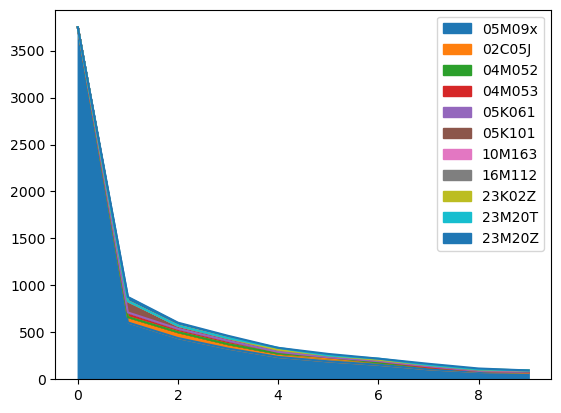

In [140]:
database.plot(kind='area')
### Graphique HTML plotly : pour le subset du dataset
fig = px.area(database, title="GHM les plus fréquents après une hospitalisation pour insuffisance cardiaque",
             labels={
                     "value": "Nombre de patients",
                     "index": "Hospitalisation n°",
                     "variable" : "GHM"
                 })
fig.write_html("data/GHM_apres_IC_subset.html")

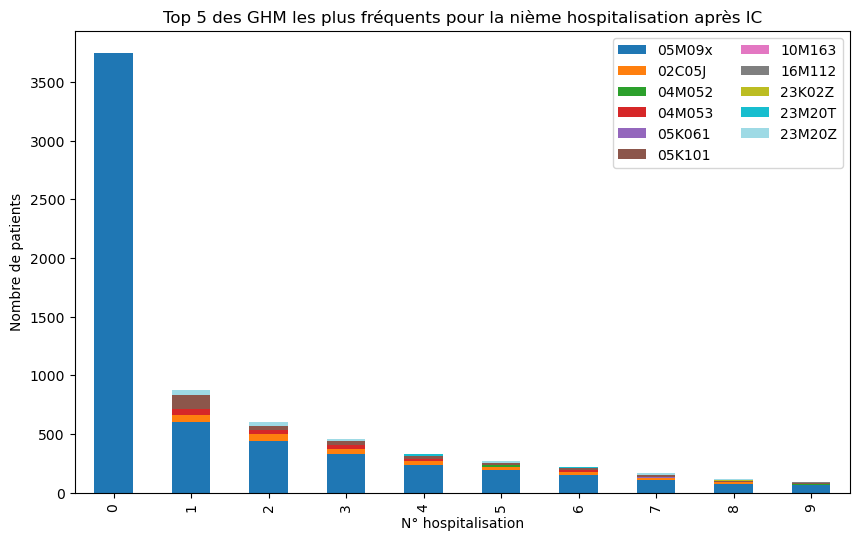

In [141]:
database.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 6))
plt.legend(loc="upper right", ncol=2)
plt.xlabel("N° hospitalisation")
plt.ylabel("Nombre de patients")
plt.title('Top 5 des GHM les plus fréquents pour la nième hospitalisation après IC')
plt.show()

## Calcul des proportions

In [142]:
prop=hospit_n[hospit_n.columns.repeat(df.shape[1])]
cols=df.columns
prop.columns=cols

In [143]:
prop.head()

,05M09x,05K101,02C05J,04M053,23M20Z,05K102,05M081,23M20T,05M08T,05K062,...,04C034,17M163,01M35T,05C214,09M111,21M152,03M073,13M051,21M151,07C071
1,3749,3749,3749,3749,3749,3749,3749,3749,3749,3749,...,3749,3749,3749,3749,3749,3749,3749,3749,3749,3749
2,3053,3053,3053,3053,3053,3053,3053,3053,3053,3053,...,3053,3053,3053,3053,3053,3053,3053,3053,3053,3053
3,2437,2437,2437,2437,2437,2437,2437,2437,2437,2437,...,2437,2437,2437,2437,2437,2437,2437,2437,2437,2437
4,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956,...,1956,1956,1956,1956,1956,1956,1956,1956,1956,1956
5,1571,1571,1571,1571,1571,1571,1571,1571,1571,1571,...,1571,1571,1571,1571,1571,1571,1571,1571,1571,1571


In [144]:
df=df/prop

In [145]:
df.head()

,05M09x,05K101,02C05J,04M053,23M20Z,05K102,05M081,23M20T,05M08T,05K062,...,04C034,17M163,01M35T,05C214,09M111,21M152,03M073,13M051,21M151,07C071
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.198166,0.039306,0.018998,0.01605,0.01474,0.012774,0.010481,0.009826,0.008844,0.008189,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.18014,0.013541,0.025851,0.014772,0.013131,0.008207,0.005334,0.0119,0.005745,0.004924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.167178,0.014315,0.024029,0.018405,0.012781,0.006135,0.005624,0.009202,0.006135,0.004601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.151496,0.01464,0.022915,0.011458,0.011458,0.003183,0.000637,0.012731,0.003183,0.007002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
# Export des différents types d'hospitalisations et de leurs proportions
df.to_csv("./data/hospit_IC_prop.csv")

In [147]:
%%capture capt
fig = px.area(df, title="Proportions de GHM après une hospitalisation pour insuffisance cardiaque",
             labels={
                     "value": "Proportion",
                     "index": "Hospitalisation n°",
                     "variable" : "GHM"
                 })
fig.write_html("data/GHM_apres_IC_prop.html")

In [148]:
len_parcours=10
top_k=5

L=[]
for i in range(len_parcours):
    L.append(df.iloc[i].sort_values(ascending=False)[:top_k])
    
database={}
for i in range(len_parcours):
    database[f'{i}']=L[i].sort_values(ascending=False)[:top_k]

database= pd.DataFrame(database)
database= database.transpose()

# on met le GHM pour IC en position 0
colonnes = list(database.columns)
colonnes.remove('05M09x')
colonnes=['05M09x']+colonnes
database=database[colonnes]

database.head()

,05M09x,02C05J,04M052,04M053,05K061,05K101,10M163,16M112,23K02Z,23M20T,23M20Z
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.198166,0.018998,NaN,0.01605,NaN,0.039306,NaN,NaN,NaN,NaN,0.01474
2,0.18014,0.025851,NaN,0.014772,NaN,0.013541,NaN,NaN,NaN,NaN,0.013131
3,0.167178,0.024029,NaN,0.018405,NaN,0.014315,NaN,NaN,NaN,NaN,0.012781
4,0.151496,0.022915,NaN,0.011458,NaN,0.01464,NaN,NaN,NaN,0.012731,NaN


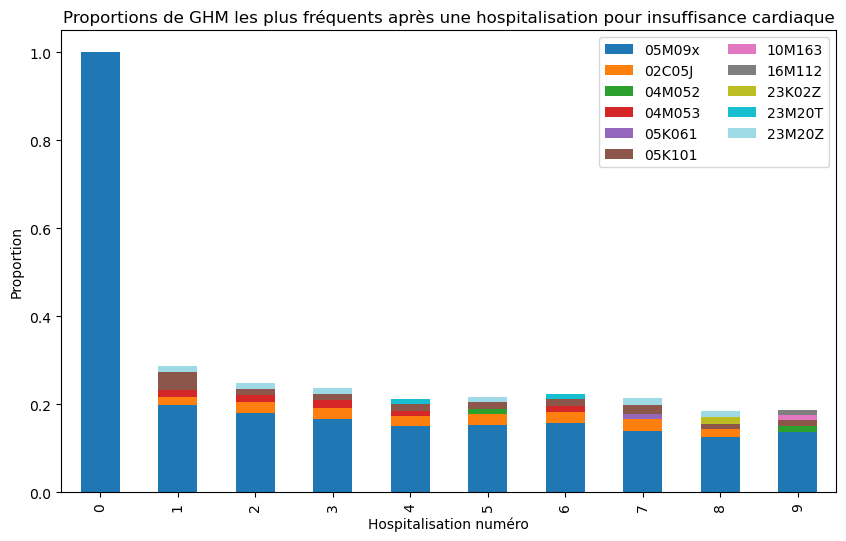

In [149]:
database.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 6))
plt.legend(loc="upper right", ncol=2)
plt.xlabel("Hospitalisation numéro")
plt.ylabel("Proportion")
plt.title('Proportions de GHM les plus fréquents après une hospitalisation pour insuffisance cardiaque')
plt.show()

In [150]:
fig = px.area(database, title="Proportions de GHM les plus fréquents après une hospitalisation pour insuffisance cardiaque",
             labels={
                     "value": "Proportion",
                     "index": "Hospitalisation n°",
                     "variable" : "GHM"
                 })
fig.show()
fig.write_html("data/GHM_apres_IC_prop_subset.html")

## Différents DP pour la nième hospitalisation

In [97]:
%%capture capt
p_soins_dp=pd.read_csv("./data/parcours_soins_dgn_pal.csv")

In [98]:
p_soins_dp.head()

,BEN_NIR_IDT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
p_soins_dp_list=[]
for patient in tqdm(range(len(p_soins_dp))):
    p_soins_dp_list.append(p_soins_dp.iloc[patient].dropna().tolist()[1:-1])

100%|██████████████████████████████████████████████████████████████████████████| 10051/10051 [00:05<00:00, 1721.19it/s]


In [151]:
p_soins_IC_df.iloc[:,:2]

,1,2
0,05M09T,05M092
1,05M093,04M132
2,05M093,04M143
3,05M091,05M171
4,05M091,23K02Z
...,...,...
3744,05M093,23M20Z
3745,05M091,23K02Z
3746,05M093,10M182
3747,05M094,05M09T
